In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models, optimizers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.applications import VGG16
import copy

In [2]:
def reconstruct_label(label): 
    #max_dist = label[-1]
    return np.array([(label[i], label[i+1]) for i in range(0, len(label), 2)])

In [3]:
X = np.load("./dataset/X.npy")
y = np.load("./dataset/y.npy")

X_h = np.load("./dataset/X_h.npy")
y_h = np.load("./dataset/y_h.npy")

X_v = np.load("./dataset/X_v.npy")
y_v = np.load("./dataset/y_v.npy")

X_d = np.load("./dataset/X_d.npy")
y_d = np.load("./dataset/y_d.npy")

X_ad = np.load("./dataset/X_ad.npy")
y_ad = np.load("./dataset/y_ad.npy")


X_vid = np.load("./dataset/X_vid.npy")
y_vid = np.load("./dataset/y_vid.npy")

In [4]:
X_stacked = np.stack((X, X_h, X_v, X_d, X_ad))
y_stacked = np.stack((y, y_h, y_v, y_d, y_ad))


In [5]:
X_stacked = np.swapaxes(X_stacked, 0, 1)
y_stacked = np.swapaxes(y_stacked, 0, 1)

#X_vid = np.swapaxes(X_vid, 0, 1)
#y_vid = np.swapaxes(y_vid, 0, 1)

In [6]:
print(X_stacked.shape)

(497, 5, 224, 224, 3)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_stacked/255, y_stacked, random_state=42, test_size=0.3)


In [8]:
X_train = X_train.reshape(-1, *X_train.shape[2:])
X_test = X_test.reshape(-1, *X_test.shape[2:])

In [9]:
y_train = y_train.reshape(-1, *y_train.shape[2:])
y_test = y_test.reshape(-1, *y_test.shape[2:])

In [10]:
print(np.shape(X_train))
print(np.shape(X_test))

(1735, 224, 224, 3)
(750, 224, 224, 3)


In [11]:
# stack video data on top of X_tran y_train
X_train =  np.concatenate((X_train, X_vid/255))
y_train =  np.concatenate((y_train, y_vid))

In [12]:
print(np.shape(X_train))

(2207, 224, 224, 3)


In [13]:
conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(224, 224, 3))


In [14]:
X_test_backup = copy.copy(X_test)
X_train_backup = copy.copy(X_train)
X_train = conv_base.predict(X_train)
X_test =  conv_base.predict(X_test)


24/24 [==============================] - 58s 2s/step


In [15]:
model = models.Sequential()

model.add(layers.Input(shape=(7, 7, 512)))

model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))


model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(14, activation='linear'))


In [16]:
def loss(y_true, y_pred):
    # Calculate the squared difference between the true and predicted values
    squared_difference = tf.square(y_true - y_pred)
    
    # Return the mean squared difference over the batch
    return tf.reduce_mean(squared_difference, axis=-1)  # Mean over each example in the batch


In [17]:
model.compile(optimizer='adam',
              loss=loss,
              metrics=['mean_squared_error'])  


In [18]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7, 7, 256)         1179904   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         295040    
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 128)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 64)                73792     
                                                                 
 dense_1 (Dense)             (None, 14)                910       
                                                        

In [18]:
history = model.fit(X_train, y_train, epochs=30, validation_split=0.1)

Epoch 1/30
63/63 [==============================] - 3s 37ms/step - loss: 2499.6687 - mean_squared_error: 2499.6687 - val_loss: 1161.9703 - val_mean_squared_error: 1161.9703
Epoch 2/30
63/63 [==============================] - 2s 36ms/step - loss: 1179.4622 - mean_squared_error: 1179.4622 - val_loss: 471.2551 - val_mean_squared_error: 471.2551
Epoch 3/30
63/63 [==============================] - 2s 37ms/step - loss: 1037.9912 - mean_squared_error: 1037.9912 - val_loss: 317.8627 - val_mean_squared_error: 317.8627
Epoch 4/30
63/63 [==============================] - 2s 37ms/step - loss: 915.4363 - mean_squared_error: 915.4363 - val_loss: 269.2448 - val_mean_squared_error: 269.2448
Epoch 5/30
63/63 [==============================] - 2s 37ms/step - loss: 774.0171 - mean_squared_error: 774.0171 - val_loss: 606.3345 - val_mean_squared_error: 606.3345
Epoch 6/30
63/63 [==============================] - 2s 37ms/step - loss: 619.3465 - mean_squared_error: 619.3465 - val_loss: 365.8042 - val_mean_sq

In [19]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
69/69 [==============================] - 3s 46ms/step - loss: 2248.7532 - mean_squared_error: 2248.7532 - val_loss: 1175.8096 - val_mean_squared_error: 1175.8096
Epoch 2/30
69/69 [==============================] - 3s 45ms/step - loss: 988.5707 - mean_squared_error: 988.5707 - val_loss: 945.5267 - val_mean_squared_error: 945.5267
Epoch 3/30
69/69 [==============================] - 3s 49ms/step - loss: 842.5352 - mean_squared_error: 842.5352 - val_loss: 851.4684 - val_mean_squared_error: 851.4684
Epoch 4/30
69/69 [==============================] - 3s 44ms/step - loss: 714.5369 - mean_squared_error: 714.5369 - val_loss: 772.8033 - val_mean_squared_error: 772.8033
Epoch 5/30
69/69 [==============================] - 3s 43ms/step - loss: 618.0271 - mean_squared_error: 618.0271 - val_loss: 781.6334 - val_mean_squared_error: 781.6334
Epoch 6/30
69/69 [==============================] - 3s 41ms/step - loss: 530.9347 - mean_squared_error: 530.9347 - val_loss: 708.1055 - val_mean_square

In [20]:
predictions = model.predict(X_test)

24/24 [==============================] - 0s 14ms/step


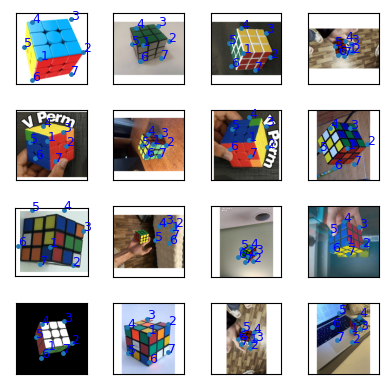

In [21]:
plt.figure(figsize=(4,4))
for i in range(16):
    plt.subplot(4,4,i+1)
    #plt.xticks([])
    #plt.yticks([])
    plt.grid(False)
    j = np.random.randint(0,len(X_test))
    label = reconstruct_label(predictions[j])
    plt.imshow(X_test_backup[j])
    plt.xticks([])
    plt.yticks([])
    for i in range(7):
        plt.text(label[i, 0], label[i, 1], str(i+1), fontsize=9, color='blue')
    plt.scatter(label[:,0],label[:,1], s=6)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    #plt.xlabel("Image "+str(i))
    #plt.axis("off")

#plt.subplots_adjust(hspace=0.5)  # Adjust space to prevent overlap
plt.tight_layout()

In [22]:
model.save('find_corners.keras')

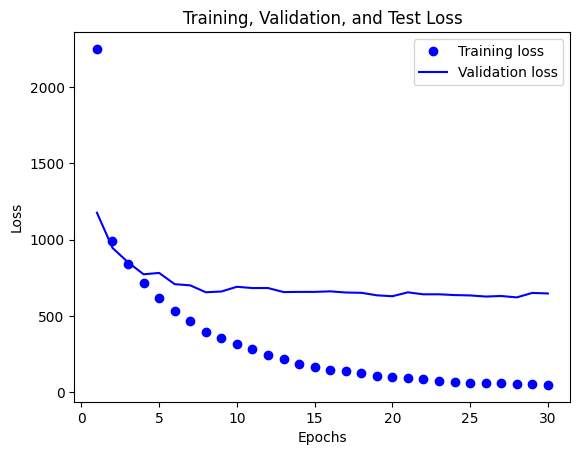

In [24]:
# Lists to store loss values
train_loss = []
val_loss = []
test_loss = []

# Loop over epochs
for epoch in range(1, len(history.history['loss']) + 1):
    train_loss.append(history.history['loss'][epoch - 1])
    val_loss.append(history.history['val_loss'][epoch - 1])

# Extracting epochs
epochs = range(1, len(train_loss) + 1)

# Plotting training, validation, and test loss
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
#plt.plot(epochs, test_loss, 'r', label='Test loss')  # Plot test loss in red
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
